In [3]:
import numpy as np
import sympy as sp
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
from time import time
from skimage.metrics import structural_similarity

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondienets a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Aca los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imagenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixels en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interes. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,0),(0,1)$ y $(0,2)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(0,0),(1,0)$ y $(2,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

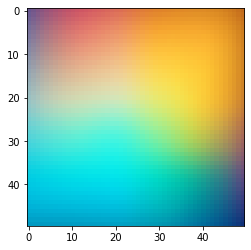

In [40]:
#Codigo para abrir y visualizar imágenes
img = Image.open('./imagenes_prueba/gradient.png').convert('RGB')
array = np.array(img)
imgplot = plt.imshow(array)
plt.show()

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas de los puntos obtenidas

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [41]:
def equispacePoints(a, b):
    """
    Parameters
    ----------
    a: (int) lado izquierdo del intervalo 
    b: (int) lado derecho del intervalo
    
    Returns
    -------
    points: (int array) puntos esquipaciados del intervalo [a, b]

    """
    points = np.array(range(1, b + 1))
    return points

In [42]:
def chebyshevPoints(a, b, n):
    """
    Parameters
    ----------
    a: (int) lado izquierdo del intervalo 
    b: (int) lado derecho del intervalo
    n: (int) cantidad de puntos a crear
    
    Returns
    -------
    points: (int array) n puntos chebyshev del intervalo [a, b]

    """
    points = []
    for i in range(1, n + 1):
        points.append((b + a) / 2.0 + ((b - a) / 2.0) * np.cos((2.0 * i - 1) * np.pi / (2.0 * n)))
    points.sort()
    return np.array(points)

In [43]:
"""
Divided_Diferrences y Newton son funciones obtenidas del github del profesor Torres.
"""

def Divided_Differences(x, y):
    dd = np.array([y]).astype('double')
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)
    
def Newton(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y}
    return D

In [44]:
def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:	(int array) points values
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    d:	(float array) derivative value of interpolated points

    """
    cantValues = len(values)
    if cheb:
        x = chebyshevPoints(0, cantValues - 1, cantValues)
    else:
        x = equispacePoints(0, cantValues)
    d = []
    if method == "lagrange":
        poly = interpolate.lagrange(x, values)
        poly = poly.deriv()
        for val in x:
            d.append(poly(val))
    elif method == "newton":
        poly = Newton(x, values)
        for val in x:
            y = poly['P'][1]
            f = val - x[0]
            f_deriv = 1
            for i in range(2, len(poly['P']) - 1):
                g = val - x[i - 1]
                y += poly['P'][i] * (f + f_deriv * g)
                f_deriv = f + f_deriv * g
                f = f * g
            d.append(y)
    elif method == "spline3":
        poly = interpolate.CubicSpline(x, values)
        poly = poly.derivative()
        for val in x:
            d.append(poly(val))
        
    d = np.array(d)
    return d


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [45]:
def p(x, y, a):
    """
    Parameters
    ----------
    x: (float) coordenada x a evaluar la función p(x, y)
    y: (float) coordenada y a evaluar la función p(x, y)
    a: (float array) coeficientes a_ij para evaluar la función p(x, y)
    
    Returns
    -------
    res: (float) resultado de evaluar p(x, y) con los coeficientes a

    """
    res = 0
    for j in range(0, 4):
        for i in range(0, 4):
            res += a[4 * j + i] * y**j * x**i
    return res

In [46]:
def newCoords(p, i, j):
    """
    Parameters
    ----------
    p: (int) cantidad de pixeles a agregar entre pixeles
    i: (int) coordenada i de la matriz original
    j: (int) coordenada j de la matriz original
    
    Returns
    -------
    tuple: (int tuple) los valores de las nuevas coordenas en la imagen con pixeles extras

    """
    return p * i + i, p * j + j

In [47]:
def bicubicInterpolation(image, interiorPixels, method, cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    eP = interiorPixels
    
    n = image.shape[0]

    newN = n + eP * (n - 1)
    newImage = np.zeros((newN, newN, 3))

    fx = np.zeros((n, n, 3))
    fy = np.zeros((n, n, 3))
    fxy = np.zeros((n, n, 3))
    
    
    for i in range(1, n - 1):
        for j in range(0, n):
            xr1, xr2, xr3 = [image[j][i - 1][0], image[j][i][0], image[j][i + 1][0]]
            xg1, xg2, xg3 = [image[j][i - 1][1], image[j][i][1], image[j][i + 1][1]]
            xb1, xb2, xb3 = [image[j][i - 1][2], image[j][i][2], image[j][i + 1][2]]
            #print("Puntos")
            #print(xr1, xr2, xr3)
            yr1, yr2, yr3 = [image[i - 1][j][0], image[i][j][0], image[i + 1][j][0]] 
            yg1, yg2, yg3 = [image[i - 1][j][1], image[i][j][1], image[i + 1][j][1]] 
            yb1, yb2, yb3 = [image[i - 1][j][2], image[i][j][2], image[i + 1][j][2]] 

            drx1, drx2, drx3 = derivativeValues(np.array([xr1, xr2, xr3]), method, cheb)
            #print("Derivadas")
            #print(drx1, drx2, drx3)
            dgx1, dgx2, dgx3 = derivativeValues(np.array([xg1, xg2, xg3]), method, cheb)
            dbx1, dbx2, dbx3 = derivativeValues(np.array([xb1, xb2, xb3]), method, cheb)
            
            dry1, dry2, dry3 = derivativeValues(np.array([yr1, yr2, yr3]), method, cheb)
            dgy1, dgy2, dgy3 = derivativeValues(np.array([yg1, yg2, yg3]), method, cheb)
            dby1, dby2, dby3 = derivativeValues(np.array([yb1, yb2, yb3]), method, cheb)
            if i == 1:
                fx[j][i - 1][0] = drx1
                fx[j][i - 1][1] = dgx1
                fx[j][i - 1][2] = dbx1
                fy[i - 1][j][0] = dry1
                fy[i - 1][j][1] = dgy1
                fy[i - 1][j][2] = dby1
                
            fx[j][i][0] = drx2
            fx[j][i][1] = dgx2
            fx[j][i][2] = dbx2
            fy[i][j][0] = dry2
            fy[i][j][1] = dgy2
            fy[i][j][2] = dby2
            
            if i == n - 2:
                fx[j][i + 1][0] = drx3
                fx[j][i + 1][1] = dgx3
                fx[j][i + 1][2] = dbx3
                fy[i + 1][j][0] = dry3
                fy[i + 1][j][1] = dgy3
                fy[i + 1][j][2] = dby3

    for i in range(1, n - 1):
        for j in range(0, n):
            
            xr1, xr2, xr3 = [fy[j][i - 1][0], fy[j][i][0], fy[j][i + 1][0]]
            xg1, xg2, xg3 = [fy[j][i - 1][1], fy[j][i][1], fy[j][i + 1][1]]
            xb1, xb2, xb3 = [fy[j][i - 1][2], fy[j][i][2], fy[j][i + 1][2]]
            
            drx1, drx2, drx3 = derivativeValues(np.array([xr1, xr2, xr3]), method, cheb)
            dgx1, dgx2, dgx3 = derivativeValues(np.array([xg1, xg2, xg3]), method, cheb)
            dbx1, dbx2, dbx3 = derivativeValues(np.array([xb1, xb2, xb3]), method, cheb)
            
            if i == 1:
                fxy[j][i - 1][0] = drx1
                fxy[j][i - 1][1] = dgx1
                fxy[j][i - 1][2] = dbx1
                
            fxy[j][i][0] = drx2
            fxy[j][i][1] = dgx2
            fxy[j][i][2] = dbx2
            
            if i == n - 2:
                fxy[j][i + 1][0] = drx3
                fxy[j][i + 1][1] = dgx3
                fxy[j][i + 1][2] = dbx3

        
    A = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]]
    A = np.linalg.inv(np.array(A))
    for i in range(1, n):
        for j in range(1, n):
            
            x = np.array([image[i - 1][j - 1][0], image[i][j - 1][0], image[i - 1][j][0], image[i][j][0],
                          fx[i - 1][j - 1][0], fx[i][j - 1][0], fx[i - 1][j][0], fx[i][j][0],
                          fy[i - 1][j - 1][0], fy[i][j - 1][0], fy[i - 1][j][0], fy[i][j][0],
                          fxy[i - 1][j - 1][0], fxy[i][j - 1][0], fxy[i - 1][j][0], fxy[i][j][0]])
            ar = np.dot(A, x)
            x = np.array([image[i - 1][j - 1][1], image[i][j - 1][1], image[i - 1][j][1], image[i][j][1],
                          fx[i - 1][j - 1][1], fx[i][j - 1][1], fx[i - 1][j][1], fx[i][j][1],
                          fy[i - 1][j - 1][1], fy[i][j - 1][1], fy[i - 1][j][1], fy[i][j][1],
                          fxy[i - 1][j - 1][1], fxy[i][j - 1][1], fxy[i - 1][j][1], fxy[i][j][1]])
            ag = np.dot(A, x)
            
            x = np.array([image[i - 1][j - 1][2], image[i][j - 1][2], image[i - 1][j][2], image[i][j][2],
                          fx[i - 1][j - 1][2], fx[i][j - 1][2], fx[i - 1][j][2], fx[i][j][2],
                          fy[i - 1][j - 1][2], fy[i][j - 1][2], fy[i - 1][j][2], fy[i][j][2],
                          fxy[i - 1][j - 1][2], fxy[i][j - 1][2], fxy[i - 1][j][2], fxy[i][j][2]])
            ab = np.dot(A, x)
            
            newI, newJ = newCoords(eP, i - 1, j)
            newImage[newI][newJ] = image[i - 1][j][:]
            newI, newJ = newCoords(eP, i , j - 1)
            newImage[newI][newJ] = image[i][j - 1][:]
            newI, newJ = newCoords(eP, i, j)
            newImage[newI][newJ] = image[i][j][:]
            newI, newJ = newCoords(eP, i - 1, j - 1)
            newImage[newI][newJ] = image[i - 1][j - 1][:]
            points = np.linspace(0, 1, eP + 2)
            
            for k in range(0, eP + 2):
                for l in range(0, eP + 2):
                    if (k == 0 and l == 0) or (k == 0 and l == eP + 1):
                        continue
                    elif (k == eP + 1 and l == 0) or (k == eP + 1 and l == eP + 1):
                        continue
                    
                    pixelValueR = p(points[k], points[l], ar)
                    pixelValueG = p(points[k], points[l], ag)
                    pixelValueB = p(points[k], points[l], ab)
                    
                    if pixelValueR > 255:
                        newImage[newI + k][newJ + l][0] = 255
                    elif pixelValueR < 0:
                        newImage[newI + k][newJ + l][0] = 0
                    else:
                        newImage[newI + k][newJ + l][0] = pixelValueR
                    if pixelValueB > 255:
                        newImage[newI + k][newJ + l][1] = 255
                    elif pixelValueB < 0:
                        newImage[newI + k][newJ + l][1] = 0
                    else:
                        newImage[newI + k][newJ + l][1] = pixelValueG
                    
                    if pixelValueB > 255:
                        newImage[newI + k][newJ + l][2] = 255
                    elif pixelValueB < 0:
                        newImage[newI + k][newJ + l][2] = 0
                    else:
                        newImage[newI + k][newJ + l][2] = pixelValueB
    return newImage.astype('int32')

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion , en segundos.(5 puntos)

In [48]:
def timeInterpolation(image, interiorPixels, method, cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    time:	(float) time in seconds

    """
    start = time()
    bicubicInterpolation(image, interiorPixels, method, cheb)
    end = time()
    
    return end - start

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

El metodo que presenta mayor velocidad en general es el método de newton, luego lo sigue las splines y lagrange llega como el método más lento. 

Esto se realizo con el código más adelante el cual permite testear la imagen que hayan ingresado arriba, con interiorPixels entre 1 a 4

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [49]:
def errorInterpolation(original, new):
    """
    Parameters
    ----------
    image:    (nxn array) original image array in RGB format
    new:    (nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:    (float) difference between images 

    """
    error = 1 - structural_similarity(original, new, multichannel=True, data_range=new.shape[0])
    
    return error

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

Utilizando las imagenes de gradiente con 1 pixel y 4 pixel, se pudo observar que los 3 métodos tienen errores bastante cercarnos entre ellos, donde sin puntos de chebyshev para la imagen con 1 pixel el menor error lo presentaba newton, y para la imagen con 4 pixeles el menor error lo presentaba la spline cubica. Pero con puntos de chebyshev para la imagen con 1 pixel el menor error lo presentaba la spline cúbica y  para la imagen con 4 pixeles el menor error lo presentaba lagrange.

# Consideraciones

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)

## PD

Aquí hay dos secciones que en los cuales se compara la imagen gradient (ingresada mucho más arriba) en tiempo con los diferentes métodos y cantidad de pixeles entre 1 y 4. Además se comparo los errores con las respectivas imaganes reales.

# Tiempos

In [50]:
"""
def times(array):
    lagrageTime = []
    newtonTime = []
    splineTime = []
    lagrageTimeCheb = []
    newtonTimeCheb = []
    splineTimeCheb = []
    print("INICIANDO")
    i = 1
    while(i <= 4):
        print(i, "CHARGING...")
        print("LAGRANGE NO CHEB CHARGING...")
        lagrageTime.append(timeInterpolation(array, i, "lagrange", False))
        print("LAGRANGE NO CHEB READY!")
        print("LAGRANGE CHEB CHARGING...")
        lagrageTimeCheb.append(timeInterpolation(array, i, "lagrange", True))
        print("LAGRANGE CHEB READY!")
        print("NEWTON NO CHEB CHARGING...")
        newtonTime.append(timeInterpolation(array, i, "newton", False))
        print("NEWTON NO CHEB READY!")
        print("NEWTON CHEB CHARGING...")
        newtonTimeCheb.append(timeInterpolation(array, i, "newton", True))
        print("NEWTON CHEB READY!")
        print("SPLINE NO CHEB CHARGING...")
        splineTime.append(timeInterpolation(array, i, "spline3", False))
        print("SPLINE NO CHEB READY!")
        print("SPLINE CHEB CHARGING...")
        splineTimeCheb.append(timeInterpolation(array, i, "spline3", True))
        print("SPLINE CHEB READY!")
        print(i, "READY!")
        i += 1
        
    return np.array([1, 2, 3, 4]), lagrageTime, newtonTime, splineTime, lagrageTimeCheb, newtonTimeCheb, splineTimeCheb
"""

In [51]:
"""
x, L, N, S, LC, NC, SC = times(array)
"""

INICIANDO
1 CHARGING...
LAGRANGE NO CHEB CHARGING...
LAGRANGE NO CHEB READY!
LAGRANGE CHEB CHARGING...
LAGRANGE CHEB READY!
NEWTON NO CHEB CHARGING...
NEWTON NO CHEB READY!
NEWTON CHEB CHARGING...
NEWTON CHEB READY!
SPLINE NO CHEB CHARGING...
SPLINE NO CHEB READY!
SPLINE CHEB CHARGING...
SPLINE CHEB READY!
1 READY!
2 CHARGING...
LAGRANGE NO CHEB CHARGING...
LAGRANGE NO CHEB READY!
LAGRANGE CHEB CHARGING...
LAGRANGE CHEB READY!
NEWTON NO CHEB CHARGING...
NEWTON NO CHEB READY!
NEWTON CHEB CHARGING...
NEWTON CHEB READY!
SPLINE NO CHEB CHARGING...
SPLINE NO CHEB READY!
SPLINE CHEB CHARGING...
SPLINE CHEB READY!
2 READY!
3 CHARGING...
LAGRANGE NO CHEB CHARGING...
LAGRANGE NO CHEB READY!
LAGRANGE CHEB CHARGING...
LAGRANGE CHEB READY!
NEWTON NO CHEB CHARGING...
NEWTON NO CHEB READY!
NEWTON CHEB CHARGING...
NEWTON CHEB READY!
SPLINE NO CHEB CHARGING...
SPLINE NO CHEB READY!
SPLINE CHEB CHARGING...
SPLINE CHEB READY!
3 READY!
4 CHARGING...
LAGRANGE NO CHEB CHARGING...
LAGRANGE NO CHEB READY!
LA

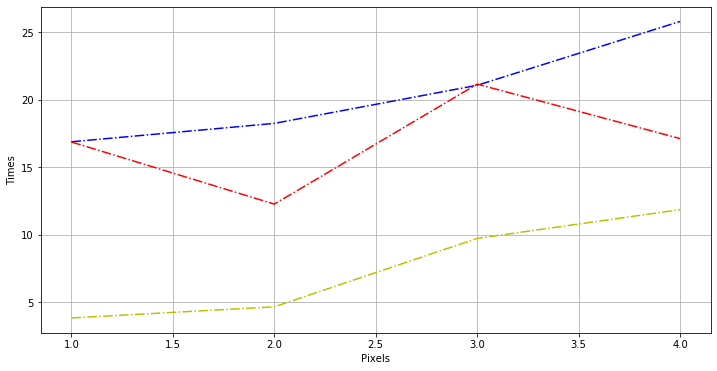

In [52]:
"""
plt.figure(figsize=(12, 6))
plt.plot(x, L, 'b-.')
plt.plot(x, N, 'y-.')
plt.plot(x, S, 'r-.')
plt.grid(True)
plt.ylabel("Times")
plt.xlabel("Pixels")
plt.show()
"""

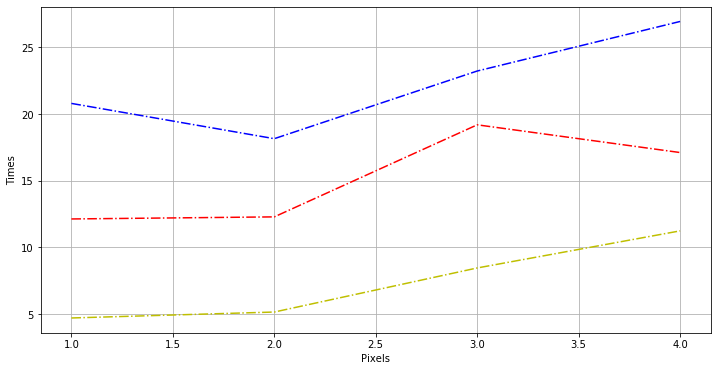

In [53]:
"""
plt.figure(figsize=(12, 6))
plt.plot(x, LC, 'b-.')
plt.plot(x, NC, 'y-.')
plt.plot(x, SC, 'r-.')
plt.grid(True)
plt.ylabel("Times")
plt.xlabel("Pixels")
plt.show()
"""

# Errores

In [54]:
"""
#Codigo para abrir y visualizar imágenes
original1 = Image.open('./imagenes_prueba/gradient_1pixel.png')
original1 = np.array(original1)
original4 = Image.open('./imagenes_prueba/gradient_4pixel.png')
original4 = np.array(original4)
"""

In [55]:
"""
print("1 pixel extra entre pixeles")
print("---------------------------")
print("No Cheb")
newArray = bicubicInterpolation(array, 1, "lagrange", False)
print("Lagrange", errorInterpolation(original1, newArray))
newArray = bicubicInterpolation(array, 1, "newton", False)
print("Newton", errorInterpolation(original1, newArray))
newArray = bicubicInterpolation(array, 1, "spline3", False)
print("Spline", errorInterpolation(original1, newArray))
print("---------------------------")
print("Cheb")
newArray = bicubicInterpolation(array, 1, "lagrange", True)
print("Lagrange", errorInterpolation(original1, newArray))
newArray = bicubicInterpolation(array, 1, "newton", True)
print("Newton", errorInterpolation(original1, newArray))
newArray = bicubicInterpolation(array, 1, "spline3", True)
print("Spline", errorInterpolation(original1, newArray))
print("4 pixel extra entre pixeles")
print("---------------------------")
print("No Cheb")
newArray = bicubicInterpolation(array, 4, "lagrange", False)
print("Lagrange", errorInterpolation(original4, newArray))
newArray = bicubicInterpolation(array, 4, "newton", False)
print("Newton", errorInterpolation(original4, newArray))
newArray = bicubicInterpolation(array, 4, "spline3", False)
print("Spline", errorInterpolation(original4, newArray))
print("---------------------------")
print("Cheb")
newArray = bicubicInterpolation(array, 4, "lagrange", True)
print("Lagrange", errorInterpolation(original4, newArray))
newArray = bicubicInterpolation(array, 4, "newton", True)
print("Newton", errorInterpolation(original4, newArray))
newArray = bicubicInterpolation(array, 4, "spline3", True)
print("Spline", errorInterpolation(original4, newArray))
"""

1 pixel extra entre pixeles
---------------------------
No Cheb
Lagrange 0.009002519666592601
Newton 0.008932318625939017
Spline 0.009002519666592601
---------------------------
Cheb
Lagrange 0.009147845093798956
Newton 0.0090639788331206
Spline 0.009063399107622772
4 pixel extra entre pixeles
---------------------------
No Cheb
Lagrange 0.011020640340876686
Newton 0.01115230028384373
Spline 0.011020640340876686
---------------------------
Cheb
Lagrange 0.012450496376305131
Newton 0.012504434866652425
Spline 0.012451890372618735


In [4]:
A = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]]
A = np.linalg.inv(np.array(A))

In [5]:
print(A)


[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-3.  3. -0. -0. -2. -1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [ 2. -2.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -3.  3. -0. -0. -2. -1. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. -2.  0.  0.  1.  1.  0.  0.]
 [-3. -0.  3. -0. -0. -0. -0. -0. -2. -0. -1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -3. -0.  3. -0. -0. -0. -0. -0. -2. -0. -1. -0.]
 [ 9. -9. -9.  9.  6.  3. -6. -3.  6. -6.  3. -3.  4.  2.  2.  1.]
 [-6.  6.  6. -6. -3. -3.  3.  3. -4.  4. -2.  2. -2. -2. -1. -1.]
 [ 2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0. -2.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [-6.  6.  6. -6. -4. -2.  4.  2. -3.  3. -3.  3. -2. -1. -2. 